In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

/home/andrei2/anaconda3/lib/python3.5/site-packages/pyne/serpent.py:11: QAWarning: pyne.serpent is not yet QA compliant.
  warn(__name__ + " is not yet QA compliant.", QAWarning)


73.6576984609 13.4306847757 6.02046782714
U in storage (total) 6.019624 t, -0.561943 t left at EOL


<IPython.core.display.Javascript object>


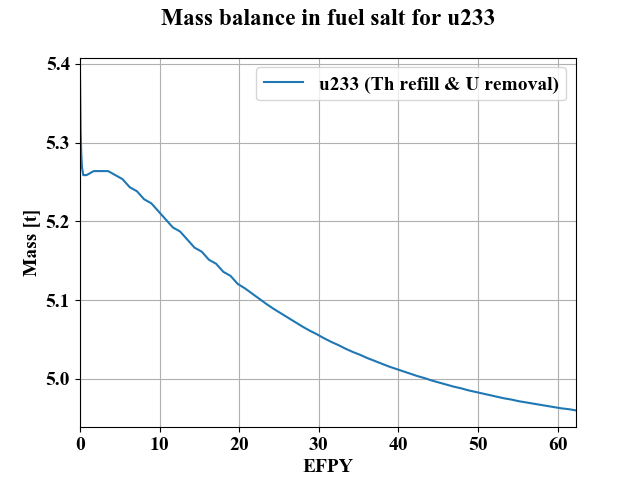

<IPython.core.display.Javascript object>


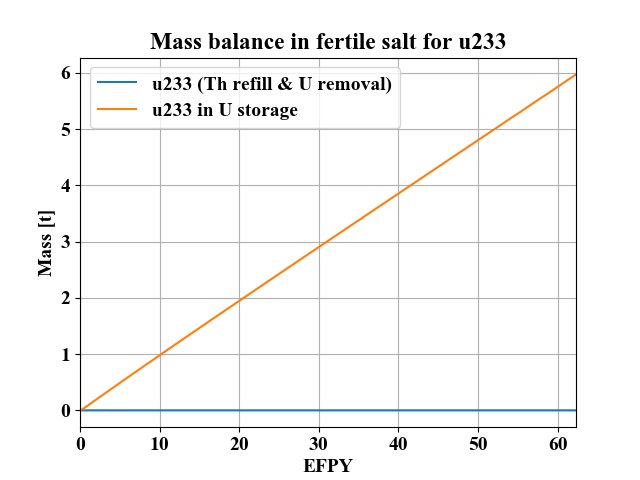

<IPython.core.display.Javascript object>


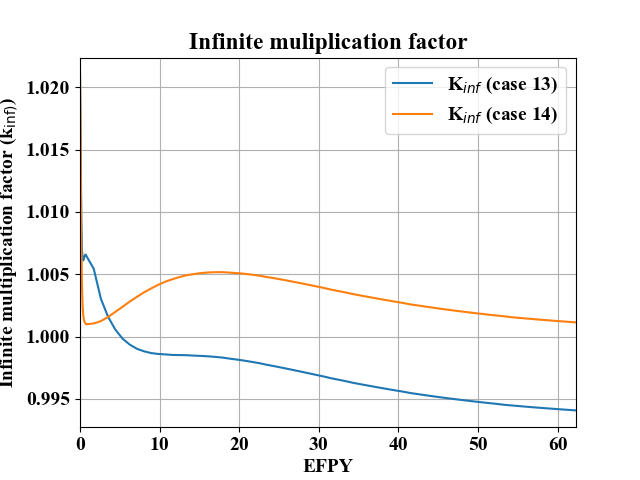

Breeding gain 89.0655681845 kg/year
Breeding gain coefficient 0.016535
Doubling time (net) 60.4776281482 yrs
u233 inventory in driver at the beginning and end of cycle [5.3864741378132379, 4.9598530599379149] t
u233 inventory in blanket at the beginning and end of cycle [2.8246704667134624e-17, 0.00078725390124954398] t

Normalization coefficient for driver (fuel) 51.153702324803966
Normalization coefficient for blanket (fertile) 114.96292864975491

Total power generated over lifetime 93.4520530701 GWe-y
Fed material: U238 in driver 56.884501, U238 in blanket 2.091830
Natural Thorium required per energy generated 0.624691321469 t/GWe-y, Bin ID: A

Fission Products reprocessed continuously over lifetime 69.4154344169 t
SNF+HLW overlifetime 80.777698304 t
Mass of SNF+HLW disposed per energy generated 0.863186529381 t/GWe-y, Bin ID: A

Products from Rep/Sep technology RU: 8.729957, RTh 41.906647, TRU: 0.360090, FP: 69.508930.
U233 fed into driver over lifetime 6.5815671334e+00 t
Adjusting

In [2]:
%matplotlib notebook 
# Import modules
import numpy as np
import matplotlib.pyplot
from pyne import serpent
from pyne import nucname
from scipy.stats.stats import pearsonr 
from scipy.stats import linregress
import itertools
matplotlib.pyplot.rcParams["font.family"] = "Times New Roman"
matplotlib.pyplot.rcParams["font.size"] = 14

file_prefix = '/home/andrei2/Desktop/forAndrei/msfr16(14)/'
##### Input parameters ####################
power = 3.0*0.5                             # GW electric
vol_driver= 18.0E+6
vol_blank = 7.3E+6
MTHM_fuel = 43.33535
MTHM_blank= 17.57098
u238_feed_f = 6.6810919754E-04                 # g/(s*MTIHM) from SCALE input
u238_feed_b = 6.0593516692E-05                 #3.165731223E-04                 # g/(s*MTIHM) from SCALE input
u233_feed_f = 5.5E-05
normaliz_coeff = MTHM_fuel/8.471613e-1        # MTIHM for T=0 / Normalized HM mass (t) from *.out [97.29472420072297]
vol_fuel_se      = normaliz_coeff
vol_blank_se     = normaliz_coeff             #[133.75523/3.031515e-1]#[441.2158071612657]
vol_pu_storage   = normaliz_coeff             #[133.75523/3.031515e-1]
vol_unirradiated = MTHM_blank/1.528387e-1-normaliz_coeff #(239.66)/8.471596e-1
vol_waste        = normaliz_coeff             #vol_driver * (51.263294/390632.937500)     # in brackets volume ratio from SCALE output (mix4/mix1)
iso = 'u233'
waste_iso = 'xe134'
# SCALE output
# U238 feed in both, Pu removal from blanket
filename_fuel_feed2 = '/home/andrei2/Desktop/forAndrei/msfr11(9)/msfr_all_removal_th_feed_60yrs_2.000000000000000000.plt'

filename_fuel_feed  = file_prefix + 'msfr_all_removal_th_feed_60yrs_2.000000000000000000.plt'
filename_blank_feed = file_prefix + 'msfr_all_removal_th_feed_60yrs_2.000000000000000001.plt'
filename_waste  = file_prefix + 'msfr_all_removal_th_feed_60yrs_2.000000000000000002.plt'
filename_pu     = file_prefix + 'msfr_all_removal_th_feed_60yrs_2.000000000000000003.plt'
k_file_feed = '/home/andrei2/Desktop/forAndrei/msfr11(9)/msfr_all_removal_th_feed_60yrs_2.out'
k_file_2    = '/home/andrei2/Desktop/forAndrei/msfr14(12)/msfr_all_removal_th_feed_60yrs_2.out'
k_file_3    = '/home/andrei2/Desktop/forAndrei/msfr15(13)/msfr_all_removal_th_feed_60yrs_2.out'
k_file_4    = file_prefix + 'msfr_all_removal_th_feed_60yrs_2.out'

def read_scale_out (filename):
    iso       = []
    adens     = []
    days_list = []
    with open(filename,'r') as infile:
        for line in itertools.islice(infile, 5, None):  # Skip file header start=6, stop=None
            p = line.split()
            iso.append(str(p[0]))
            adens.append(p[1:])  
            #iso.append(str(p[2]))
            #adens.append(str(p[3]))
    #u_en = 1e-6* np.flip (np.array (upp_enrg, dtype=float), 0 )               # Convert eV to MeV
    #flux = np.flip ( np.array (flux_list, dtype=float), 0 )
    #num_gr = len (u_en)
    days_list.append (iso[0])
    days_list = days_list + adens[0][:]
    adens_arr = np.asarray(adens[1:][:], dtype=np.float32)
    days = np.array (days_list, dtype=np.float32)
    return iso[1:], days/365, adens_arr/1e+6

def read_scale_k (filename):
    kinf = []
    with open(filename) as openfile:
        for line in openfile:
            if line.startswith('      Infinite neutron multiplication'):
                num = line.split(' ')[-1].strip()
                kinf.append(float(num))
    return kinf #[1:]

def heavy_metal_mass (iso_name, days, mdens, vol):
    iso = []
    mthm = 0.0
    for k in range (len(iso_name)-2):
        if nucname.znum(iso_name[k]) > 89:
            iso.append(iso_name[k])
            mthm += mdens[k] * vol
    return mthm

def mass_of_elements (n_sc, mdens, vol, list_of_elements):
    mass = []
    for k in list_of_elements:
        for g in range(len(n_sc)-2):
            if nucname.znum(k) == nucname.znum(n_sc[g]):
                mass.append(mdens[g,-1]*vol )
    return np.sum(mass)                          # total mass, t

kinf_feed = read_scale_k (k_file_feed)
kinf_2    = read_scale_k (k_file_2)
kinf_3    = read_scale_k (k_file_3)
kinf_4    = read_scale_k (k_file_4)

# Feed and Pu removal case
n_f_feed, days_sc_f, mdens_f_feed       = read_scale_out (filename_fuel_feed)
n_b_feed, days_sc_f, mdens_b_feed       = read_scale_out (filename_blank_feed)
n_sc_waste, days_sc_f, mdens_waste      = read_scale_out (filename_waste)
n_sc_pu, days_sc_pu, mdens_pu           = read_scale_out (filename_pu)
n_f_feed2, days_sc_f2, mdens_f_feed2       = read_scale_out (filename_fuel_feed2)
# Heavy metal inventory
u238_0  =  (mdens_f_feed[n_f_feed.index('u238'),0]+mdens_b_feed[n_b_feed.index('u238'),0])*vol_fuel_se
u235_0  =  (mdens_f_feed[n_f_feed.index('u235'),0]+mdens_b_feed[n_b_feed.index('u235'),0])*vol_fuel_se
pu239_0 =  (mdens_f_feed[n_f_feed.index('pu239'),0]+mdens_b_feed[n_b_feed.index('pu239'),0])*vol_fuel_se

u238_e  =  (mdens_f_feed[n_f_feed.index('u238'),-1]+mdens_b_feed[n_b_feed.index('u238'),-1])*vol_fuel_se
u235_e  =  (mdens_f_feed[n_f_feed.index('u235'),-1]+mdens_b_feed[n_b_feed.index('u235'),-1])*vol_fuel_se
pu239_e =  (mdens_f_feed[n_f_feed.index('pu239'),-1]+mdens_b_feed[n_b_feed.index('pu239'),-1])*vol_fuel_se

#MTHM_fuel                               = heavy_metal_mass (n_sc4, days_sc, mdens_fuel_sc4,vol_fuel_se)
#MTHM_blanket                            = heavy_metal_mass (n_sc_blanket4, days_sc, mdens_blank_sc4,vol_blank_se)
#MTHM_pu                                 = heavy_metal_mass (n_sc_pu, days_sc, mdens_pu,vol_blank_se)

tot_m_feed= mdens_f_feed[n_f_feed.index('u233'),]*vol_fuel_se+mdens_b_feed[n_b_feed.index('u233'),]*vol_blank_se+mdens_pu[n_sc_pu.index('u233'),]*vol_pu_storage
tot_u233_feed = 1e-6*u233_feed_f*(MTHM_fuel+MTHM_blank)*3600*24*365*days_sc_f[-1]
# Online reprocessed materials
# U238 fed over lifetime
u238_f_consumed = u238_feed_f * MTHM_fuel * days_sc_f[-1] * 24 * 365 * 3600 * 1e-6   # t uranium fed into the core
u238_b_consumed = u238_feed_b *MTHM_blank * days_sc_f[-1] * 24 * 365 * 3600 * 1e-6   # t uranium fed into the blanket
u_balance     =  u235_0+u238_0+u238_f_consumed+u238_b_consumed-u235_e-u238_e                # initial U + fed U - U left after 60yrs
# FP removed continuously over lifetime
fp_removed    = mdens_waste[n_sc_waste.index('total')][-1]*vol_waste
# FP in fuel salt after 60 years of irradiation
gases_list    = ['kr','xe','ar','h','n','o']
noble_list    = ['se','nb','mo','tc','ru','rh','pd','ag','sb','te','zr','cd','in','sn']
rare_list     = ['y','la','ce','pr','nd','pm','sm','gd','eu','dy','ho','er','tb','ga','ge','as']
discard_list  = ['cs','ba','rb','sr']
fp_list = gases_list+noble_list+rare_list+discard_list
fp_left = mass_of_elements(n_f_feed, mdens_f_feed, vol_fuel_se, fp_list)+mass_of_elements(n_b_feed, mdens_b_feed, vol_blank_se, fp_list)

##### Recovered materials from the fuel salt
recovered_mat_list = ['f','li','be','th','u','pu']                  # list of useful materials we wanna recover after reactor shutdown
mass_recovered_mat = mass_of_elements(n_f_feed, mdens_f_feed, vol_fuel_se, recovered_mat_list)+mass_of_elements(n_b_feed, mdens_b_feed, vol_fuel_se, recovered_mat_list)+mass_of_elements(n_sc_pu, mdens_pu, vol_pu_storage, recovered_mat_list)
print (mass_of_elements(n_f_feed, mdens_f_feed, vol_fuel_se, recovered_mat_list), 
       mass_of_elements(n_b_feed, mdens_b_feed, vol_fuel_se, recovered_mat_list),
       mass_of_elements(n_sc_pu, mdens_pu, vol_waste, recovered_mat_list))

##################### Fuel cycle metrics Generated (2.1.14) ###############
nat_u_per_energy = u_balance / (power*days_sc_f[-1])                        # Natural Uranium per energy generated
snf_hlw_per_energy= (fp_removed+4.1249*(vol_driver+vol_blank)*1e-6-mass_recovered_mat)/(power*days_sc_f[-1])  # SNF+HLW per energy generated
if nat_u_per_energy>=0 and nat_u_per_energy<3.8:
    metric_resource_utilization = 'A'
elif nat_u_per_energy>=3.8 and nat_u_per_energy<35.0:
    metric_resource_utilization = 'B'
elif nat_u_per_energy>=35.0 and nat_u_per_energy<145.0:
    metric_resource_utilization = 'C'
else: 
    metric_resource_utilization = 'D'

if snf_hlw_per_energy>=0 and snf_hlw_per_energy<1.65:
    metric_mass_of_snf_hlw = 'A'
elif snf_hlw_per_energy>=1.65 and snf_hlw_per_energy<3.0:
    metric_mass_of_snf_hlw = 'B'
elif snf_hlw_per_energy>=3.0 and snf_hlw_per_energy<6.0:
    metric_mass_of_snf_hlw = 'C'
elif snf_hlw_per_energy>=6.0 and snf_hlw_per_energy<=12.0:
    metric_mass_of_snf_hlw = 'D'
elif snf_hlw_per_energy>=12 and snf_hlw_per_energy<=36:
    metric_mass_of_snf_hlw = 'E'
else: 
    metric_mass_of_snf_hlw = 'F'

print ('U in storage (total) %f t, %f t left at EOL' %(mass_of_elements(n_sc_pu, mdens_pu, vol_pu_storage, ['u233']),
                                        mass_of_elements(n_sc_pu, mdens_pu, vol_pu_storage, ['u233'])-tot_u233_feed) )
    
    
############################### GRAPHIC HERE ##############################################################
# Initialize figure
fig_1 = matplotlib.pyplot.figure(1)
ax = fig_1.add_subplot(111)
ax.grid(True)
ax.ticklabel_format (style='sci',scilimits=(0,0),axis='y')
#ax.set_ylim(0,0.00555)
#for i in [n_se1.index(iso.capitalize())]:
#    ax.plot(days, mdens_fuel_se1[i,:]*vol_fuel_se[0], '-',color='red',
#            label=nucname.serpent(n_se1[i])+' Serpent(gases removal)')
#for i in [n_se2.index(iso.capitalize())]:
#    ax.plot(days, mdens_fuel_se2[i,:]*vol_fuel_se[0], '--',color='green', 
#            label=nucname.serpent(n_se2[i])+' Serpent(volatile gases, noble metals, \nrare earths&discard)')
#for k in [iso]:
#    ax.plot(days_sc, mdens_fuel_sc[n_sc.index(k)]*vol_fuel_se[0], '-',color='#ff8100', label=k+'(no removals)')
#for k in [iso]:
#    ax.plot(days_sc, mdens_fuel_sc1[n_sc1.index(k)]*vol_fuel_se[0], '+--',color='blue', label=k+'(gases)')
#for k in [iso]:
#    ax.plot(days_sc, mdens_fuel_sc2[n_sc2.index(iso)]*vol_fuel_se[0], '-',color='black', label=k+'(gases&noble)')
#for k in [iso]:
#    ax.plot(days_sc, mdens_fuel_sc0[n_sc0.index(k)]*vol_fuel_se[0], '--', label=k+' (no reprocessing)')
for k in [iso]:
    ax.plot(days_sc_pu, mdens_f_feed[n_f_feed.index(k)]*vol_fuel_se, '-', label=k+' (Th refill & U removal)')
#for k in [iso]:
#    ax.plot(days_sc, mdens_fuel_sc4[n_sc4.index(k)]*vol_fuel_se+mdens_blank_sc4[n_sc_blanket4.index(k)]*vol_blank_se, 
#            '-', label='Total')
ax.legend(loc=0)
ax.set_ylabel('Mass [t]')
ax.set_xlabel('EFPY')
ax.set_title('Mass balance in fuel salt for ' + str (iso)+'\n')
ax.set_xlim([0,np.amax(days_sc_pu)])
#ax.set_xlim ([0,1])
#ax.set_ylim([0, np.amax(tot_mass_sc)])
fig_1.show()
#fig_1.savefig(str(iso)+'_core.png',bbox_inches='tight', dpi=900)

# Initialize figure
fig_2 = matplotlib.pyplot.figure(2)
ax = fig_2.add_subplot(111)
ax.grid(True)
ax.ticklabel_format (style='sci',scilimits=(0,0),axis='y')
#for i in [n_se.index(iso.capitalize())]:
#    ax.plot(days, mdens_blank_se[i,:]*vol_blank_se[0], '-',color='#ff8100', label=nucname.serpent(n_se[i])+' (no removals)')
#for i in [n_se1.index(iso.capitalize())]:
#    ax.plot(days, mdens_blank_se1[i,:]*vol_blank_se[0], '-',color='red', label=nucname.serpent(n_se1[i])+' Serpent(gases removal)')
#for i in [n_se2.index(iso.capitalize())]:
#    ax.plot(days, mdens_blank_se2[i,:]*vol_blank_se[0], '--',color='blue', label=nucname.serpent(n_se2[i])+' Serpent(volatile gases, noble metals, \nrare earths&discard)')
#for k in [iso]:
#    ax.plot(days_sc, mdens_blank_sc[n_sc_blanket.index(k)]*vol_blank_se[0], '-',color='#ff8100', label=k+'(no removals)')
#for k in [iso]:
#    ax.plot(days_sc, mdens_blank_sc1[n_sc_blanket1.index(k)]*vol_blank_se[0], '+--',color='blue', label=k+'(gases)')
#for k in [iso]:
#    ax.plot(days_sc, mdens_blank_sc2[n_sc_blanket2.index(k)]*vol_blank_se[0], '-',color='black', label=k+'(gases&noble)')
#for k in [iso]:
#    ax.plot(days_sc, mdens_blank_sc0[n_sc_blanket0.index(k)]*vol_blank_se[0], '+--',label=k+' (no reprocessing)')
#for k in [iso]:
#    ax.plot(days_sc, mdens_blank_sc4[n_sc_blanket4.index(k)]*vol_blank_se[0], '-', label=k+' (no $^{238}$U refill)')
for k in [iso]:
    ax.plot(days_sc_pu, mdens_b_feed[n_b_feed.index(k)]*vol_blank_se+
            mdens_b_feed[n_b_feed.index(k),0]*vol_unirradiated, '-', label=k+' (Th refill & U removal)')
for k in [iso]:
    ax.plot(days_sc_pu, mdens_pu[n_sc_pu.index(k)]*vol_pu_storage, '-', label=k+' in U storage')

ax.legend(loc=0)
ax.set_ylabel('Mass [t]')
ax.set_xlabel('EFPY')
ax.set_title('Mass balance in fertile salt for ' + str (iso))
ax.set_xlim([0,np.amax(days_sc_pu)])
#ax.set_xlim ([0,4])
#ax.set_ylim ([0,np.amax()])
fig_2.show()
#fig_2.savefig(str(iso)+'_blanket.png',bbox_inches='tight', dpi=700)

# Initialize figure
fig_4 = matplotlib.pyplot.figure(4)
ax = fig_4.add_subplot(111)
ax.grid(True)
#ax.plot(days_sc, kinf0, '-',color='#ff8100', label='no removals')
#ax.plot(days_sc, kinf1, '-',color='blue', label='gases')
#ax.plot(days_sc, kinf2, '-',color='black', label='gases&noble')
#ax.plot(days_sc, kinf3, '-',color='red', label='gases&noble\n&rare earths')
#ax.plot(days_sc, kinf0, '-', label='K$_{inf}$ (no reprocessing)')
#ax.plot(days_sc_pu, kinf_feed, '-', label='K$_{inf}$ (case 8)')
#ax.plot(days_sc_pu, kinf_2, '-', label='K$_{inf}$ (case 12)')  #10
ax.plot(days_sc_pu, kinf_3, '-', label='K$_{inf}$ (case 13)')  #11
ax.plot(days_sc_pu, kinf_4, '-', label='K$_{inf}$ (case 14)') #12
ax.legend(loc=0)
ax.set_ylabel('Infinite multiplication factor (k$_{\inf)}$)')
ax.set_xlabel('EFPY')
ax.set_title('Infinite muliplication factor')
ax.set_xlim([0,np.amax(days_sc_pu)])
#ax.set_xlim ([0,4])
#ax.set_ylim ([0.97, 1.02])
fig_4.show()
#fig_4.savefig('k_inf.png',bbox_inches='tight', dpi=700)
'''
# Initialize figure
fig_5 = matplotlib.pyplot.figure(5)
ax = fig_5.add_subplot(111)
ax.grid(True)
ax.plot(days_sc, MTHM_fuel, '-',color='green', label='MTHM in core')
ax.plot(days_sc, MTHM_blanket, '-',color='blue', label='MTHM in blanket')
#ax.plot(days_sc, MTHM_pu, '-',color='#ff8100', label='MTHM in Pu tank')
ax.legend(loc=0)
ax.set_ylabel('Metric tons')
ax.set_xlabel('EFPD')
ax.set_title('Heavy Metal Loading')
ax.set_xlim([0,np.amax(days_sc)])
fig_4.show()
#fig_4.savefig('k_inf_Th_feed.png',bbox_inches='tight', dpi=700)
'''

print ('Breeding gain ' + str (1e+3*(tot_m_feed[-1]-tot_m_feed[0])/days_sc_f[-1]) + ' kg/year' )
print ('Breeding gain coefficient ' + str ((tot_m_feed[-1] - tot_m_feed[0])/(tot_m_feed[0] * days_sc_f[-1])) )
print ('Doubling time (net) ' + str( 1/((tot_m_feed[-1] - tot_m_feed[0])/(tot_m_feed[0] * days_sc_f[-1]))  ) + ' yrs')

##print (tot_mass_sc[-1] - tot_mass_sc[0])
print (str(iso)+' inventory in driver at the beginning and end of cycle '+ 
       str ([mdens_f_feed[n_f_feed.index(iso),0]*vol_fuel_se,
            mdens_f_feed[n_f_feed.index(iso),-1]*vol_fuel_se])  + ' t' )
print (str(iso)+' inventory in blanket at the beginning and end of cycle '+ 
       str ([mdens_b_feed[n_b_feed.index(iso),0]*vol_blank_se+mdens_b_feed[n_b_feed.index(iso),0]*vol_unirradiated,
            mdens_b_feed[n_b_feed.index(iso),-1]*vol_blank_se+mdens_b_feed[n_b_feed.index(iso),0]*vol_unirradiated])  + ' t' )
#print (mdens_fuel_sc4[n_sc_blanket4.index(iso),0]*vol_fuel_se)

print('\nNormalization coefficient for driver (fuel) ' + str (MTHM_fuel/8.471596e-1)    )
print('Normalization coefficient for blanket (fertile) ' + str (MTHM_blank/(1-8.471596e-1))    )

print ('\nTotal power generated over lifetime ' + str (power*days_sc_f[-1]) + ' GWe-y')
print ('Fed material: U238 in driver %f, U238 in blanket %f' %(u238_f_consumed, u238_b_consumed))
print ('Natural Thorium required per energy generated ' + str ( nat_u_per_energy ) 
       + ' t/GWe-y, Bin ID: ' + str (metric_resource_utilization) )

print ('\nFission Products reprocessed continuously over lifetime ' + str ( fp_removed) + ' t')
print ('SNF+HLW overlifetime ' + str (fp_removed+(mdens_f_feed[n_f_feed.index('total'),-1]+
        mdens_b_feed[n_b_feed.index('total'),-1])*vol_fuel_se + 
        mdens_b_feed[n_b_feed.index('total'),0]*vol_unirradiated - mass_recovered_mat ) + ' t' )
print ('Mass of SNF+HLW disposed per energy generated ' +
       str (snf_hlw_per_energy) +' t/GWe-y, Bin ID: '+str (metric_mass_of_snf_hlw))
#print ('Mass of DU+RU+RTh disposed per energy generated: ' + str(0) + ' Bin ID: A' )

print ('\nProducts from Rep/Sep technology RU: %f, RTh %f, TRU: %f, FP: %f.' 
       %(mass_of_elements(n_f_feed, mdens_f_feed, vol_fuel_se, ['u'])+
         mass_of_elements(n_b_feed, mdens_b_feed, vol_blank_se, ['u']),
         mass_of_elements(n_f_feed, mdens_f_feed, vol_fuel_se, ['th'])+
         mass_of_elements(n_b_feed, mdens_b_feed, vol_blank_se, ['th']),
         mass_of_elements(n_f_feed, mdens_f_feed, vol_fuel_se, ['pu','np','am','cm'])+
         mass_of_elements(n_b_feed, mdens_b_feed, vol_blank_se, ['pu','np','am','cm']),
         fp_removed+fp_left))

#print ('Cs, Ba,  Rb, Sr reprocessing group %f t; rate of removal %.10e g/(s*MTU)'
#       %(mass_of_elements(n_f_feed, mdens_f_feed, vol_fuel_se, ['cs','ba','rb','sr']),
#         1e+6*mass_of_elements(n_f_feed, mdens_f_feed, vol_fuel_se, ['cs','ba','rb','sr'])/(365*24*3600*MTHM_fuel*days_sc_f[-1])))

print ('U233 fed into driver over lifetime %.10e t' %(1e-6*u233_feed_f*(MTHM_fuel+MTHM_blank)*3600*24*365*days_sc_pu[-1]))
print ( "Adjusting Th232 feed rate into driver %.10e g/(s*MTU)"
      %(u238_feed_f+1e6*np.diff([mdens_f_feed[n_f_feed.index('total'),-1]*vol_fuel_se,
            mdens_f_feed[n_f_feed.index('total'),0]*vol_fuel_se])/((3600*24*365*days_sc_f[-1] - 180)*(MTHM_blank+MTHM_fuel) ) ) ) 

print ( "Adjusted Th232 feed rate into blanket %.10e g/(s*MTU)"
      %(u238_feed_b+1e6*np.diff([mdens_b_feed[n_b_feed.index('total'),-1]*vol_blank_se+
            mdens_b_feed[n_b_feed.index('total'),0]*vol_unirradiated,
            mdens_b_feed[n_b_feed.index('total'),0]*vol_blank_se+
            mdens_b_feed[n_b_feed.index('total'),0]*vol_unirradiated]) / (3600*24*365*(MTHM_blank+MTHM_fuel)*days_sc_pu[-1]) )    ) 

print ('U233 feed into the driver over 60 years %.10e t ' %((1.5E-04*(MTHM_fuel+MTHM_blank)*3600*24*300 + 
      4.5E-05*(MTHM_fuel+MTHM_blank)*3600*24*(365*days_sc_pu[-1]-300))/1e+6 ) )

balance_fuel = (mdens_f_feed[:-2,-1] - mdens_f_feed[:-2,0])*vol_fuel_se
for i in range (len(balance_fuel)):
    if balance_fuel[i] >= 0.1:
        print (balance_fuel[i], n_f_feed[i])
balance_blanket = (mdens_b_feed[:-2,-1] - mdens_b_feed[:-2,0])*vol_fuel_se
print ('Blanket')
for i in range (len(balance_blanket)):
    if balance_blanket[i] >= 0.001:
        print (balance_blanket[i]*1000, n_b_feed[i])
        
#print ('New Th-232 feed rate %.10e' %(6.6810919754E-04 - (5.5E-05-4.5E-05)) )

In [ ]:
def mass_of_elements_list (n_sc, mdens,days,vol, list_of_elements):
    mass = []
    for k in list_of_elements:
        for g in range(len(n_sc)-2):
            if nucname.znum(k) == nucname.znum(n_sc[g]):
                mass.append(mdens[g,:]*vol )
    s = np.zeros(days.shape[0])                
    for p in range(days.shape[0]):
        for l in range(len(mass)):
            s[p] += mass[l][p]
    return mass, s                          # list mass, t

def mass_of_iso_list(names, m, days, iso_list):
    mass = np.zeros(len(days))
    for k in iso_list:
        mass +=  m[names.index(k),:]
    return mass

days = days_sc_f
tot_vol = vol_blank_se+vol_unirradiated

mass_f = mdens_f_feed * vol_fuel_se
mass_b = mdens_b_feed * vol_blank_se + mdens_b_feed * vol_unirradiated
#print(mass_b[n_b_feed.index('total')])
#print(mass_b[n_b_feed.index('u233')])
#print(mass_b[n_b_feed.index('th232')])

print('Total blanket salt %f t' %(vol_blank*4.1249*1e-6) )
print('Total blanket salt mass %f t' %(mass_b[n_b_feed.index('total'),0]) )
print('Th232 blanket mass %f t' %(mass_b[n_b_feed.index('th232'),0]) )

MTHM_fuel = heavy_metal_mass (n_f_feed, days, mdens_f_feed,vol_fuel_se)
MTHM_blank = heavy_metal_mass (n_b_feed, days, mdens_b_feed,tot_vol) 
MTHM = MTHM_blank + MTHM_fuel
# Uranium balance
u_list = ['u233','u234','u235','u236','u232','u237','u238','u235m','u239','u231','u230','u240','u241']
total_u_fuel = mass_of_iso_list (n_f_feed, mass_f, days, u_list)
total_u_blank= mass_of_iso_list (n_b_feed, mass_b, days, u_list)
total_u = total_u_fuel + total_u_blank
# Pu balance
pu_list = ['pu238','pu239','pu240','pu241','pu242','pu236','pu237','pu244','pu243','pu245','pu237m','pu246','pu247']
total_pu_fuel = mass_of_iso_list (n_f_feed, mass_f, days, pu_list)
total_pu_blank= mass_of_iso_list (n_b_feed, mass_b, days, pu_list)
total_pu = total_pu_fuel + total_pu_blank

print(MTHM_fuel)
print(MTHM_blank)
#print(total_u_fuel)
#print(total_u_blank)
#print(u233_dr)

# Initialize figure
fig_10 = matplotlib.pyplot.figure(10)
ax = fig_10.add_subplot(111)
ax.grid(True)
ax.plot(days, 100*total_u/MTHM, ':', label='total U')  #11
ax.plot(days, 100*(mass_f[n_f_feed.index('u233')]+mass_b[n_b_feed.index('u233')])/MTHM, '-', label=r'$^{233}$U')  
ax.plot(days, 100*(mass_f[n_f_feed.index('u234')]+mass_b[n_b_feed.index('u234')])/MTHM, '-', label=r'$^{234}$U')  
ax.plot(days_sc_pu, 100*(mass_f[n_f_feed.index('u235')]+mass_b[n_b_feed.index('u235')])/MTHM, '-', label=r'$^{235}$U')  
ax.plot(days_sc_pu, 100*(mass_f[n_f_feed.index('u236')]+mass_b[n_b_feed.index('u236')])/MTHM, '-', label=r'$^{236}$U')  
ax.legend(loc=0)
ax.set_ylabel('mass [% of total heavy metal]')
ax.set_xlabel('EFPY')
#ax.set_title('Infinite muliplication factor')
#ax.set_xlim([0,np.amax(days_sc_pu)])
ax.set_xlim([0,60])
#ax.set_xlim ([0,4])
ax.set_ylim ([0.0, 14.35])
fig_10.show()
#fig_10.savefig('/home/andrei2/Desktop/git/publications/2019-rykhl-fsmsrs-mc/Figures/msfr_u_balance.png',bbox_inches='tight', dpi=900)
matplotlib.pyplot.close

# Initialize figure
f,(ax,ax2) = matplotlib.pyplot.subplots(2,1,sharex=True,figsize=(6,7))

ax2.plot(days, 100*total_u/MTHM, ':', label='total U')  
ax.plot(days, 100*(mass_f[n_f_feed.index('th232')]+mass_b[n_b_feed.index('th232')])/MTHM, '-', label=r'$^{232}$Th')  
ax2.plot(days, 100*(mass_f[n_f_feed.index('u233')]+mass_b[n_b_feed.index('u233')])/MTHM, '-', label=r'$^{233}$U')  
ax2.plot(days, 100*(mass_f[n_f_feed.index('u234')]+mass_b[n_b_feed.index('u234')])/MTHM, '-', label=r'$^{234}$U')  
ax2.plot(days_sc_pu, 100*(mass_f[n_f_feed.index('u235')]+mass_b[n_b_feed.index('u235')])/MTHM, '-', label=r'$^{235}$U')  
#ax2.plot(days_sc_pu, 100*(mass_f[n_f_feed.index('u236')]+mass_b[n_b_feed.index('u236')])/MTHM, '-', label=r'$^{236}$U')  

#ax.grid(True)
ax.set_ylim(84.0,91.3)
ax2.set_ylim(0,14.5)

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off')  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .005  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax.grid()
ax2.grid()

ax.text(32, 86, r'$^{232}$Th')
ax2.text(12, 12.7, 'total U')
ax2.text(42, 8.5, r'$^{233}$U')
ax2.text(30, 3.95, r'$^{234}$U')
ax2.text(20, 0.95, r'$^{235}$U')

#ax.legend(loc=0)
#ax2.legend(loc=0)
ax2.set_ylabel('mass [% of total heavy metal]')
ax2.yaxis.set_label_coords(-0.1, 1.0)
ax2.set_xlabel('EFPY')
#ax.set_title('Infinite muliplication factor')
#ax.set_xlim([0,np.amax(days_sc_pu)])
ax.set_xlim([0,60])
#ax.set_xlim ([0,4])
#ax.set_ylim ([0.0, 14.35])

f.subplots_adjust(hspace=0.05)
f.show()
#f.savefig('/home/andrei2/Desktop/git/publications/2019-rykhl-fsmsrs-mc/Figures/msfr_u_balance.png',bbox_inches='tight', dpi=900)

In [ ]:
# Pu plotting

#print(total_pu_fuel)
#print(total_pu_blank)
#print(total_pu)

# Initialize figure
fig_11 = matplotlib.pyplot.figure(12)
ax = fig_11.add_subplot(111)
ax.grid(True)
ax.plot(days, 100*total_pu/MTHM, ':', label='total Pu')  #11
ax.plot(days, 100*(mass_f[n_f_feed.index('pu238')]+mass_b[n_b_feed.index('pu238')])/MTHM, '-', label=r'$^{238}$Pu')  
ax.plot(days, 100*(mass_f[n_f_feed.index('pu239')]+mass_b[n_b_feed.index('pu239')])/MTHM, '-', label=r'$^{239}$Pu')  
ax.plot(days, 100*(mass_f[n_f_feed.index('pu240')]+mass_b[n_b_feed.index('pu240')])/MTHM, '-', label=r'$^{240}$Pu')  
ax.plot(days, 100*(mass_f[n_f_feed.index('pu241')]+mass_b[n_b_feed.index('pu241')])/MTHM, '-', label=r'$^{241}$Pu')  
ax.plot(days, 100*(mass_f[n_f_feed.index('pa233')]+mass_b[n_b_feed.index('pa233')])/MTHM, '-', label=r'$^{233}$Pa')  

ax.legend(loc=0)
ax.set_ylabel('mass [% of total heavy metal]')
ax.set_xlabel('EFPY')
#ax.set_title('Infinite muliplication factor')
#ax.set_xlim([0,np.amax(days_sc_pu)])
ax.set_xlim([0,60])
#ax.set_xlim ([0,4])
ax.set_ylim ([0.0, 0.35])
fig_11.show()
#fig_11.savefig('/home/andrei2/Desktop/git/publications/2019-rykhl-fsmsrs-mc/Figures/msfr_pu_balance.png',bbox_inches='tight', dpi=900)

In [ ]:
total_energy_generated = power * days[-1]
print('Th utilization')
print('Th mass at BOL %f t' %(mass_f[n_f_feed.index('th232')][0]+mass_b[n_b_feed.index('th232')][0]) )
print('Th mass at EOL %f t' %(mass_f[n_f_feed.index('th232')][-1]+mass_b[n_b_feed.index('th232')][-1]) )
th_defect = (mass_f[n_f_feed.index('th232')][0]+mass_b[n_b_feed.index('th232')][0]) - (mass_f[n_f_feed.index('th232')][-1]+mass_b[n_b_feed.index('th232')][-1]) 
print('Th mass defect in the reactor %f t' %(th_defect))
th_driver_feed = 6.5810919754E-04 * MTHM_fuel[0] * days[-1] * 24 * 365 * 3600 * 1e-6  
th_blanket_feed = 6.0593516692E-05 * MTHM_blank[0] * days[-1] * 24 * 365 * 3600 * 1e-6
print('Th feed in the driver %f t' %th_driver_feed )
print('Th feed in the blanket %f t' %th_blanket_feed )
th_balance = th_defect + th_driver_feed + th_blanket_feed
print ('Natural thorium utilization %f t/GWe-yr' %(th_balance/total_energy_generated))

print('\nU utilization')
print('U mass at BOL %f t' %(mass_f[n_f_feed.index('u233')][0]+mass_b[n_b_feed.index('u233')][0]) )
print('U mass at EOL %f t' %(mass_f[n_f_feed.index('u233')][-1]+mass_b[n_b_feed.index('u233')][-1]) )
u_defect = (mass_f[n_f_feed.index('u233')][0]+mass_b[n_b_feed.index('u233')][0]) - (mass_f[n_f_feed.index('u233')][-1]+mass_b[n_b_feed.index('u233')][-1]) 
print('U mass defect in the rector %f t' %(u_defect))
u_driver_feed = 5.5E-05 * MTHM_fuel[0] * days[-1] * 24 * 365 * 3600 * 1e-6   # feed for all time in tons
print('U233 in storage %f t' % (mdens_pu[n_sc_pu.index('u233')][-1]*vol_pu_storage) )
u_balance = u_defect + u_driver_feed - mdens_pu[n_sc_pu.index('u233')][-1]*vol_pu_storage
print ('Natural thorium utilization %f t/GWe-yr' %(u_balance/total_energy_generated))

print('\nFission Products removed %f t' %fp_removed)
print('Useful stuff we gonna remove at the EOL %f t' %mass_recovered_mat)
tot_salt_mass = mass_f[n_f_feed.index('total')][-1]+mass_b[n_b_feed.index('total')][-1]
print('Salts mass at the EOL %f t' %(tot_salt_mass))
print('Mass of SNF+HLW disposed %f t' %(tot_salt_mass-mass_recovered_mat+fp_removed))
print('Mass of SNF+HLW disposed %f t/Gwe-yr' %((tot_salt_mass-mass_recovered_mat+fp_removed)/total_energy_generated))

In [5]:
from pyne.material import Material
nucvec = {}

# n_f_feed, days_sc_f,
#print(days_sc_f*365)
print(mdens_f_feed[n_f_feed.index('total')][0]*vol_fuel_se)
print(n_f_feed[-5:])

for iso in n_f_feed[:-2]:
    nucvec[iso] = mdens_f_feed[n_f_feed.index(iso)][57]*vol_fuel_se
#    print(mdens_f_feed[n_f_feed.index(iso)][0])

mat0 = Material(nucvec, density=4.1249)
mat0.norm_comp()

sum = 0

# print(mat0)
matf = open('msfr_composition_equil.ini', 'w')
for nuc_code, wt_frac in mat0.comp.items():
# Transforms iso name from zas to zzaaam and then to SERPENT
    iso_name_serpent = nucname.serpent(nuc_code)
    matf.write('           %9s  %7.14E\n' %
                           (iso_name_serpent+'.09c',
                            -wt_frac))
matf.close()



for i in mat0.comp.items():
    # print(i)
    sum += i[1]

print(sum)

74.2238718594
['dy154', 'tb154m', 'tb154', 'subtotal', 'total']
1.0


In [6]:
nucvec2 = {}

total_mass = []

tru_mass = []
u_mass = []
act_mass = []


for nstep in range(len(days_sc_f)):
    for iso in n_f_feed[:-2]:
        nucvec2[iso] = mdens_f_feed[n_f_feed.index(iso)][nstep]*vol_fuel_se
    mat1 = Material(nucvec2, density=4.1249)
    mat_tru = mat1.sub_tru()    
    mat_u = mat1.sub_u() 
    mat_act = mat1.sub_act()
    total_mass.append(mat1.mass)
    tru_mass.append(mat_tru.mass)
    u_mass.append(mat_u.mass)
    act_mass.append(mat_act.mass)

In [7]:
print(tru_mass)
# print(u_mass)
# print(act_mass)
tru_change = (100*np.diff(tru_mass)/tru_mass[1:])
print('TRU mass change [g]', tru_change)    
print(days_sc_f*365)
sum = 0
# print(mat0)
# matf = open('msfr_composition_equil.ini', 'w')
#for nuc_code, wt_frac in mat0.comp.items():
# Transforms iso name from zas to zzaaam and then to SERPENT
#    iso_name_serpent = nucname.serpent(nuc_code)
#    matf.write('           %9s  %7.14E\n' %
#                           (iso_name_serpent+'.09c',
#                            -wt_frac))
#matf.close()

[3.0710575045040316e-15, 2.539621031713867e-11, 6.03322613741399e-10, 3.6221865181178015e-09, 1.2571694040431147e-08, 3.253395296582078e-08, 7.010093735079057e-08, 1.3336256699067257e-07, 2.3181254365871094e-07, 3.762135070440376e-07, 5.787630796312469e-07, 1.1225400232438046e-05, 5.718088189510604e-05, 0.00017399567117683699, 0.00040200161765795666, 0.0007827737013821013, 0.0013562201955406453, 0.00215957463996291, 0.0032248556306213737, 0.004580442387098795, 0.00624825523952841, 0.008244387898706372, 0.01058601410033707, 0.01327759855197627, 0.0163202539845591, 0.01972559875366338, 0.023472609675885308, 0.02756479212574832, 0.0319857324405954, 0.03673445684784052, 0.04178850713225212, 0.04713495351724945, 0.05276590498078748, 0.058646084358561036, 0.06477239495390405, 0.07111756857787202, 0.07767290726016049, 0.08440882564765699, 0.09131120411877472, 0.09836062561198977, 0.10554668863843891, 0.11281510483634777, 0.12024640301530547, 0.12767856508465808, 0.13519721330349016, 0.1427972

<IPython.core.display.Javascript object>


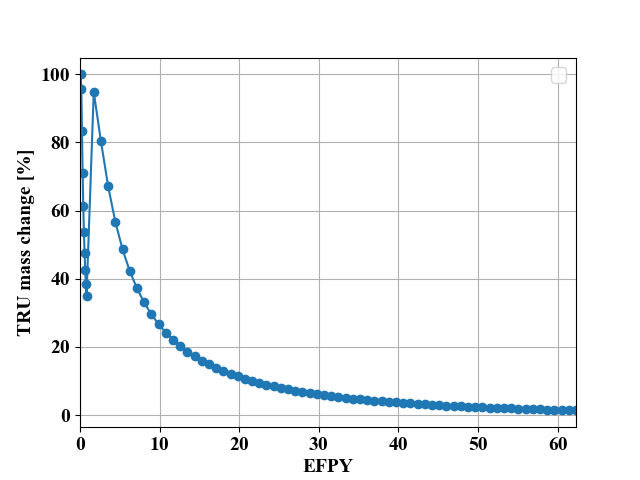

No handles with labels found to put in legend.


2.96885382518
43.3151


In [8]:
# Initialize figure
fig_13 = matplotlib.pyplot.figure(13)
ax = fig_13.add_subplot(111)
ax.grid(True)
ax.plot(days_sc_f[1:], tru_change, 'o-')  #11

ax.legend(loc=0)
ax.set_ylabel('TRU mass change [%]')
ax.set_xlabel('EFPY')
#ax.set_title('Infinite muliplication factor')
ax.set_xlim([0,np.amax(days_sc_f)])
#ax.set_xlim ([0,4])
#ax.set_ylim ([0.0, 0.35])
fig_13.show()

print(tru_change[57])
print(days_sc_f[57]) # chose 67 step